In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")
plt.rcParams['font.family'] = 'sans-serif'
csv_file = 'tenhou_bootstrap_dataset.csv'

df = pd.read_csv(csv_file)
print(f"データ件数: {len(df)} 件")
print("先頭5行のプレビュー:")
display(df.head())

データ件数: 3001 件
先頭5行のプレビュー:


,Score,Han,Fu,Junme,Dora_Count,Is_Dealer,Is_Riichi,Win_Type
0,7900,3,60,15,0,0,1,1
1,5800,3,30,15,1,1,0,0
2,12000,6,30,9,3,0,1,1
3,12000,5,25,16,2,1,1,0
4,4000,3,30,15,1,0,1,1


--- Part 1：平均得点の推定（ブートストラップ法）---
平均得点の推定値（Mean）: 5797.86
95% 信頼区間（CI）        : [5648.88, 5947.52]


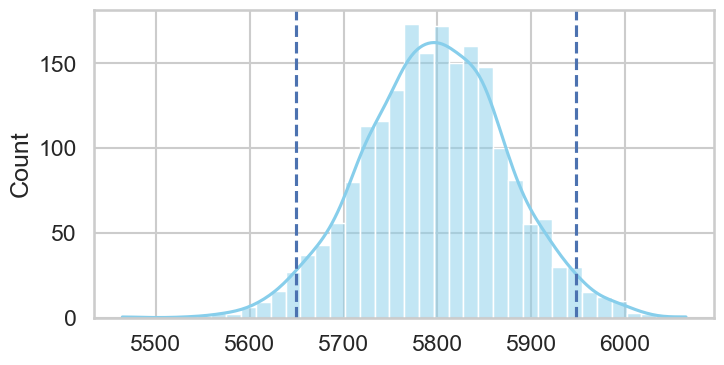

In [6]:
print("--- RQ1：平均得点の推定（ブートストラップ法）---")

# 1. リサンプリング回数の設定
n_boot = 2000
means = []

# 2. ブートストラップ抽出
np.random.seed(42)  # 乱数シードを固定し，再現性を確保
for _ in range(n_boot):
    # frac=1, replace=True：ブートストラップ法の基本（復元抽出）
    sample = df['Score'].sample(frac=1, replace=True)
    means.append(sample.mean())

# 3. 統計量の計算
mean_est = np.mean(means)
ci_low, ci_high = np.percentile(means, [2.5, 97.5])

# 4. 結果の出力
print(f"平均得点の推定値（Mean）: {mean_est:.2f}")
print(f"95% 信頼区間（CI）        : [{ci_low:.2f}, {ci_high:.2f}]")

# 5. 分布の可視化
plt.figure(figsize=(8, 4))
sns.histplot(means, kde=True, color='skyblue')
plt.axvline(ci_low, linestyle='--')
plt.axvline(ci_high, linestyle='--')
# plt.title(f"平均得点のブートストラップ分布（Mean = {mean_est:.0f}）")
plt.savefig("bootstrap_mean_score.png", dpi=300, bbox_inches="tight")
plt.show()

--- RQ2: 親(Dealer)と子(Non-Dealer)の得点差の検定 ---
親の平均得点優位性: +2772.05 点
95% 信頼区間     : [2399.67, 3151.69]
結論: 親の得点は子より有意に高い（区間が0を含まない）。
図2を 'fig2_rq2_dealer_diff.png' として保存しました。


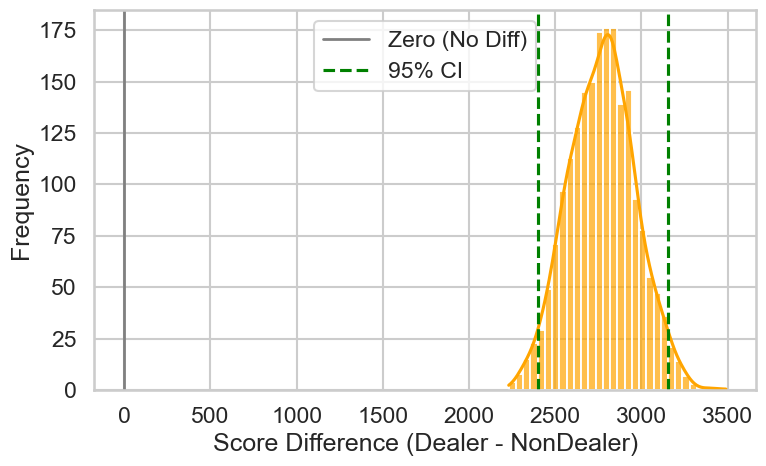

In [10]:
print("--- RQ2: 親(Dealer)と子(Non-Dealer)の得点差の検定 ---")

dealer_diffs = []

np.random.seed(42) # シード固定

# リサンプリング実行
for _ in range(n_boot):
    sample = df.sample(frac=1, replace=True)
    # 2群に分割
    group_dealer = sample[sample['Is_Dealer'] == 1]['Score']
    group_non_dealer = sample[sample['Is_Dealer'] == 0]['Score']
    
    # 平均値の差を計算（親 - 子）
    diff = group_dealer.mean() - group_non_dealer.mean()
    dealer_diffs.append(diff)

# 統計量の算出
diff_est = np.mean(dealer_diffs)
ci_low_d, ci_high_d = np.percentile(dealer_diffs, [2.5, 97.5])

# 結果表示
print(f"親の平均得点優位性: +{diff_est:.2f} 点")
print(f"95% 信頼区間     : [{ci_low_d:.2f}, {ci_high_d:.2f}]")

if ci_low_d > 0:
    print("結論: 親の得点は子より有意に高い（区間が0を含まない）。")
else:
    print("結論: 有意な差は認められない。")

# グラフ描画
plt.figure(figsize=(8, 5))
sns.histplot(dealer_diffs, kde=True, color='orange', alpha=0.7)
plt.axvline(0, color='gray', linestyle='-', linewidth=2, label='Zero (No Diff)')
plt.axvline(ci_low_d, color='green', linestyle='--', label='95% CI')
plt.axvline(ci_high_d, color='green', linestyle='--')
# plt.title(f"Bootstrap Distribution of Dealer Advantage\n(Diff={diff_est:.0f})")
plt.xlabel("Score Difference (Dealer - NonDealer)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()

# 保存
plt.savefig('fig2_rq2_dealer_diff.png', dpi=300)
print("図2を 'fig2_rq2_dealer_diff.png' として保存しました。")
plt.show()

--- RQ3: 戦略的要因の寄与度分析 (回帰モデル) ---
補足: 翻数(Han)と符数(Fu)を除外し、行動の純粋な価値を推定します。
   処理中: 0/2000
   処理中: 500/2000
   処理中: 1000/2000
   処理中: 1500/2000

変数名             平均係数       2.5% CI    97.5% CI   有意性
const           767        487        1063       ***
Is_Riichi       2137       1939       2330       ***
Dora_Count      2261       2177       2343       ***
Junme           12         -16        38            
Is_Dealer       2612       2360       2879       ***
Win_Type        1064       858        1253       ***
-----------------------------------------------------------------
注: *** は95%信頼区間が0を含まない（有意である）ことを示す。
図3を 'fig3_rq3_riichi_coef.png' として保存しました。


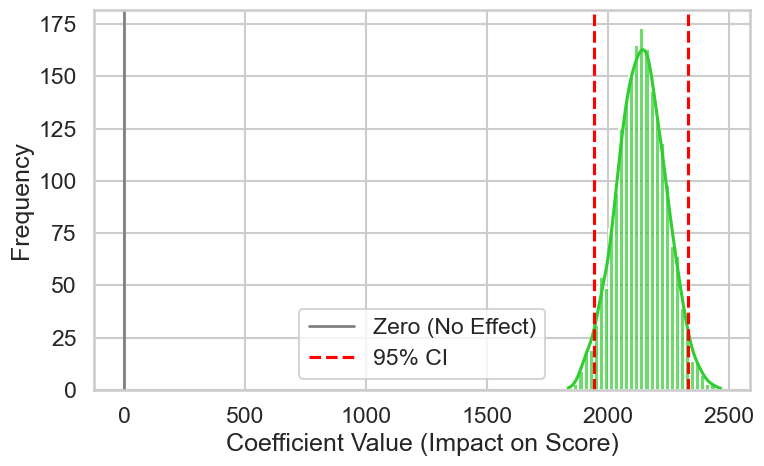

In [12]:
print("--- RQ3: 戦略的要因の寄与度分析 (回帰モデル) ---")
print("補足: 翻数(Han)と符数(Fu)を除外し、行動の純粋な価値を推定します。")

# 説明変数の定義
features = ['Is_Riichi', 'Dora_Count', 'Junme', 'Is_Dealer', 'Win_Type']
X = df[features]
X = sm.add_constant(X) # 定数項の追加
y = df['Score']

coef_list = []

np.random.seed(42) # シード固定

# ブートストラップ回帰の実行
for i in range(n_boot):
    # 進捗表示
    if i % 500 == 0: print(f"   処理中: {i}/{n_boot}")
        
    # リサンプリング
    indices = np.random.choice(df.index, size=len(df), replace=True)
    X_sample = X.iloc[indices]
    y_sample = y.iloc[indices]
    
    try:
        model = sm.OLS(y_sample, X_sample).fit()
        coef_list.append(model.params)
    except:
        continue

coef_df = pd.DataFrame(coef_list)

# 結果の集計と表示
print("\n" + "="*65)
print(f"{'変数名':<15} {'平均係数':<10} {'2.5% CI':<10} {'97.5% CI':<10} {'有意性'}")
print("="*65)

for col in coef_df.columns:
    mean_val = coef_df[col].mean()
    low = np.percentile(coef_df[col], 2.5)
    high = np.percentile(coef_df[col], 97.5)
    
    # 有意性判定
    sig = "***" if (low > 0 or high < 0) else "   "
    print(f"{col:<15} {mean_val:<10.0f} {low:<10.0f} {high:<10.0f} {sig}")

print("-" * 65)
print("注: *** は95%信頼区間が0を含まない（有意である）ことを示す。")

# グラフ描画（立直の係数分布のみをピックアップして可視化）
plt.figure(figsize=(8, 5))
riichi_coefs = coef_df['Is_Riichi']
r_low = np.percentile(riichi_coefs, 2.5)
r_high = np.percentile(riichi_coefs, 97.5)
r_mean = np.mean(riichi_coefs)

sns.histplot(riichi_coefs, kde=True, color='limegreen', alpha=0.7)
plt.axvline(0, color='gray', linestyle='-', linewidth=2, label='Zero (No Effect)')
plt.axvline(r_low, color='red', linestyle='--', label='95% CI')
plt.axvline(r_high, color='red', linestyle='--')
# plt.title(f"Bootstrap Distribution of Riichi Value\n(Coef={r_mean:.0f})")
plt.xlabel("Coefficient Value (Impact on Score)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()

# 保存
plt.savefig('fig3_rq3_riichi_coef.png', dpi=300)
print("図3を 'fig3_rq3_riichi_coef.png' として保存しました。")
plt.show()